## Urban Development and Biodiversity in Phoenix

In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001 [1]. This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.


### Data
 - Biodiversity Intactness Index (BII) Time Series
 Source: https://planetarycomputer.microsoft.com/dataset/io-biodiversity
 
 
 - Arizona State Count Subdivision Shapefile
 Source: https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision


### Load in Libraries

In [7]:
import pandas as pd
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

### Read in Data

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Pull out biodiversity collections
bdi_collection = catalog.get_child('io-biodiversity')

In [11]:
# Read in Arizona shapefile
arizona = gpd.read_file(os.path.join('data',
                  'tl_2024_04_cousub',
                  'tl_2024_04_cousub.shp'
                 ))

# Check CRS
print(f"arizona crs is: {arizona.crs}")

arizona crs is: EPSG:4269


<Axes: >

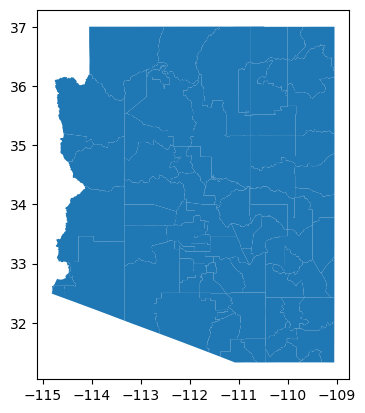

In [12]:
arizona.plot()